<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/500_Swin_UNETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries Import

In [ ]:
%pip install "monai==1.4.1rc1" -q
#%pip install torchinfo -q
#%pip install thop -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00


In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime


import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


#from torchinfo import summary
#from thop import profile


from google.colab import drive
print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.13.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.48.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

##Drive Mount

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Image, Label and FreeSurferColorLUT Directory

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
image_dir = "OASIS_500/Images"
label_dir = "OASIS_500/Labels"

In [ ]:
lut_path = "FreeSurferColorLUT.txt"

##Image & Labels Extraction and Visualization

In [ ]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))[:500]
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))[:500]

In [ ]:
len(images), len(labels)

(500, 500)

In [ ]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




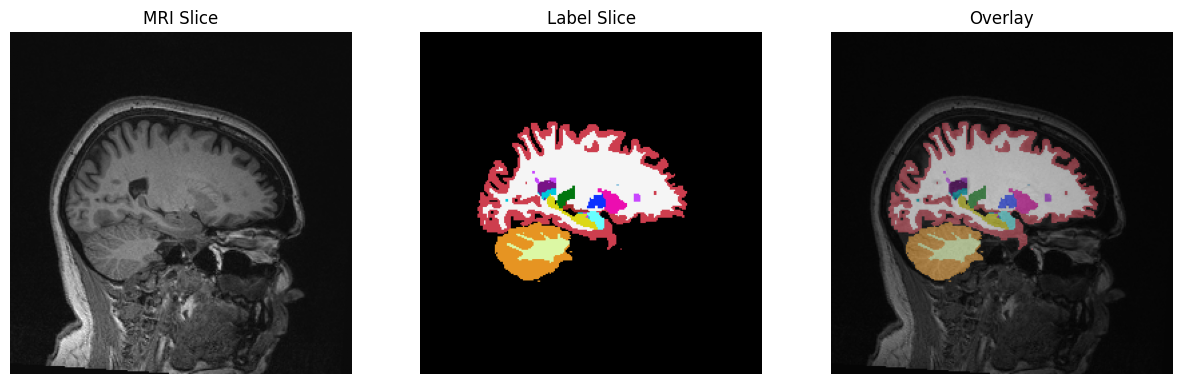

In [ ]:
visualize_image(images[245],labels[245], 110)

##Image Transforms and Custom Dataset

####Function to make labels contiguous

In [ ]:
def replace_freesurfer_index_with_contiguous(seg):
   label_index=np.unique(seg)
   for items in label_index:
     seg[seg==items]=np.where(label_index==items)[0][0]
   return seg

####Transforms

In [ ]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    Resize((128, 128, 128)),
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(replace_freesurfer_index_with_contiguous),
    ToTensor(),
    EnsureChannelFirst(),
    Resize((128, 128, 128), mode="nearest"),
])


In [ ]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


##Dataset Loading

In [ ]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]
train_files = data_dicts[:400]
val_files   = data_dicts[400:450]
test_files  = data_dicts[450:]

In [ ]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)
test_ds  = MyBrainDataset(test_files,  img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=2)

In [ ]:
def data_details (train_loader, val_loader, test_loader = None):
  print(f"Number of training samples: {len(train_loader) * train_loader.batch_size}")
  print(f"Number of validation samples: {len(val_loader) * val_loader.batch_size}")
  if test_loader:
    print(f"Number of test samples: {len(test_loader) * test_loader.batch_size}")
  train_batch = next(iter(train_loader))
  train_inputs, _ = train_batch
  print(f"Training input size: {train_inputs.shape}")

In [ ]:
data_details(train_loader, val_loader)

##Model, Optimizer and Loss Function

In [ ]:
from monai.losses import DiceCELoss

In [ ]:
set_determinism(seed=40)

num_classes = 45

model = SwinUNETR(
    img_size=(128, 128, 128),
    in_channels=1,
    out_channels=num_classes,
    feature_size=48

).cuda()

loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=0.6, lambda_ce=0.4, include_background=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

post_trans = Compose([
    Activations(softmax=True),
    AsDiscrete(argmax=True,  to_onehot=num_classes)
])


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


##Model Details

In [ ]:
summary(model, input_size=(1, 1, 128, 128, 128))

Layer (type:depth-idx)                                  Output Shape              Param #
SwinUNETR                                               [1, 45, 128, 128, 128]    --
├─SwinTransformer: 1-1                                  [1, 24, 64, 64, 64]       --
│    └─PatchEmbed: 2-1                                  [1, 24, 64, 64, 64]       --
│    │    └─Conv3d: 3-1                                 [1, 24, 64, 64, 64]       216
│    └─Dropout: 2-2                                     [1, 24, 64, 64, 64]       --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─BasicLayer: 3-2                             [1, 48, 32, 32, 32]       37,230
│    └─ModuleList: 2-4                                  --                        --
│    │    └─BasicLayer: 3-3                             [1, 96, 16, 16, 16]       120,540
│    └─ModuleList: 2-5                                  --                        --
│    │    └─BasicLayer: 3-4                       

In [ ]:
input_tensor = torch.randn(1, 1, 128, 128, 128)
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

##Functions to load and save model and checkpoints

In [ ]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [ ]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [ ]:
#epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('500old_lr-3_Checkpoint.pth')

<ipython-input-21-19b8f39b631c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


##Epochs and Validation

In [ ]:
max_epochs = 30
val_interval = 1

###Run if Checkpoints are not loaded

In [ ]:
train_loss_list = []
val_dice_list   = []
epoch_list      = []
epoch=0
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [ ]:
from tqdm import tqdm

In [ ]:
start_epoch=epoch

In [ ]:
checkpoint_path = '48_adamw_500old_lr-3_Checkpoint.pth'
best_model_path = '48_adamw500old_lr-3_best_dice_model.pth'

#Training Loop
for epoch in range(max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in tqdm(train_loader, leave=False):
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")



    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            for val_data in tqdm(val_loader, leave=False):
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (128, 128, 128)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)
        print(f"  Validation Dice: {dice_mean:.4f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")

    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)
print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")


Epoch [1/30] 2025-02-26 13:34:44.844059


  Train loss: 0.6742


  Validation Dice: 0.3880
   Saved new best model
Epoch [2/30] 2025-02-26 13:54:31.334589


  Train loss: 0.3484


  Validation Dice: 0.5899
   Saved new best model
Epoch [3/30] 2025-02-26 14:06:11.454706


  Train loss: 0.2396


  Validation Dice: 0.7013
   Saved new best model
Epoch [4/30] 2025-02-26 14:17:53.273101


  Train loss: 0.1979


  Validation Dice: 0.7147
   Saved new best model
Epoch [5/30] 2025-02-26 14:29:32.417254


  Train loss: 0.1862


  Validation Dice: 0.7313
   Saved new best model
Epoch [6/30] 2025-02-26 14:41:12.768147


  Train loss: 0.1783


  Validation Dice: 0.7342
   Saved new best model
Epoch [7/30] 2025-02-26 14:52:53.060524


  Train loss: 0.1736


  Validation Dice: 0.7414
   Saved new best model
Epoch [8/30] 2025-02-26 15:04:34.565278


  Train loss: 0.1709


  Validation Dice: 0.7404
Epoch [9/30] 2025-02-26 15:16:17.267530


  Train loss: 0.1679


  Validation Dice: 0.7442
   Saved new best model
Epoch [10/30] 2025-02-26 15:27:57.464132


  Train loss: 0.1655


  Validation Dice: 0.7493
   Saved new best model
Epoch [11/30] 2025-02-26 15:39:38.208982


  Train loss: 0.1640


  Validation Dice: 0.7441
Epoch [12/30] 2025-02-26 15:51:20.597099


  Train loss: 0.1621


  Validation Dice: 0.7499
   Saved new best model
Epoch [13/30] 2025-02-26 16:03:01.475446


  Train loss: 0.1601


  Validation Dice: 0.7515
   Saved new best model
Epoch [14/30] 2025-02-26 16:14:44.546554


  Train loss: 0.1593


  Validation Dice: 0.7529
   Saved new best model
Epoch [15/30] 2025-02-26 16:26:27.227253


  Train loss: 0.1565


  Validation Dice: 0.7568
   Saved new best model
Epoch [16/30] 2025-02-26 16:38:08.956814


  Train loss: 0.1557


  Validation Dice: 0.7567
Epoch [17/30] 2025-02-26 16:49:49.038415


  Train loss: 0.1547


  Validation Dice: 0.7582
   Saved new best model
Epoch [18/30] 2025-02-26 17:01:31.213913


  Train loss: 0.1535


  Validation Dice: 0.7558
Epoch [19/30] 2025-02-26 17:13:11.978186


  Train loss: 0.1529


  Validation Dice: 0.7601
   Saved new best model
Epoch [20/30] 2025-02-26 17:24:57.491150


  Train loss: 0.1521


  Validation Dice: 0.7579
Epoch [21/30] 2025-02-26 17:36:37.948376


  Train loss: 0.1512


  Validation Dice: 0.7604
   Saved new best model
Epoch [22/30] 2025-02-26 17:48:20.136561


KeyboardInterrupt: 

##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(21, 21, 21)

In [ ]:
max_epochs=21

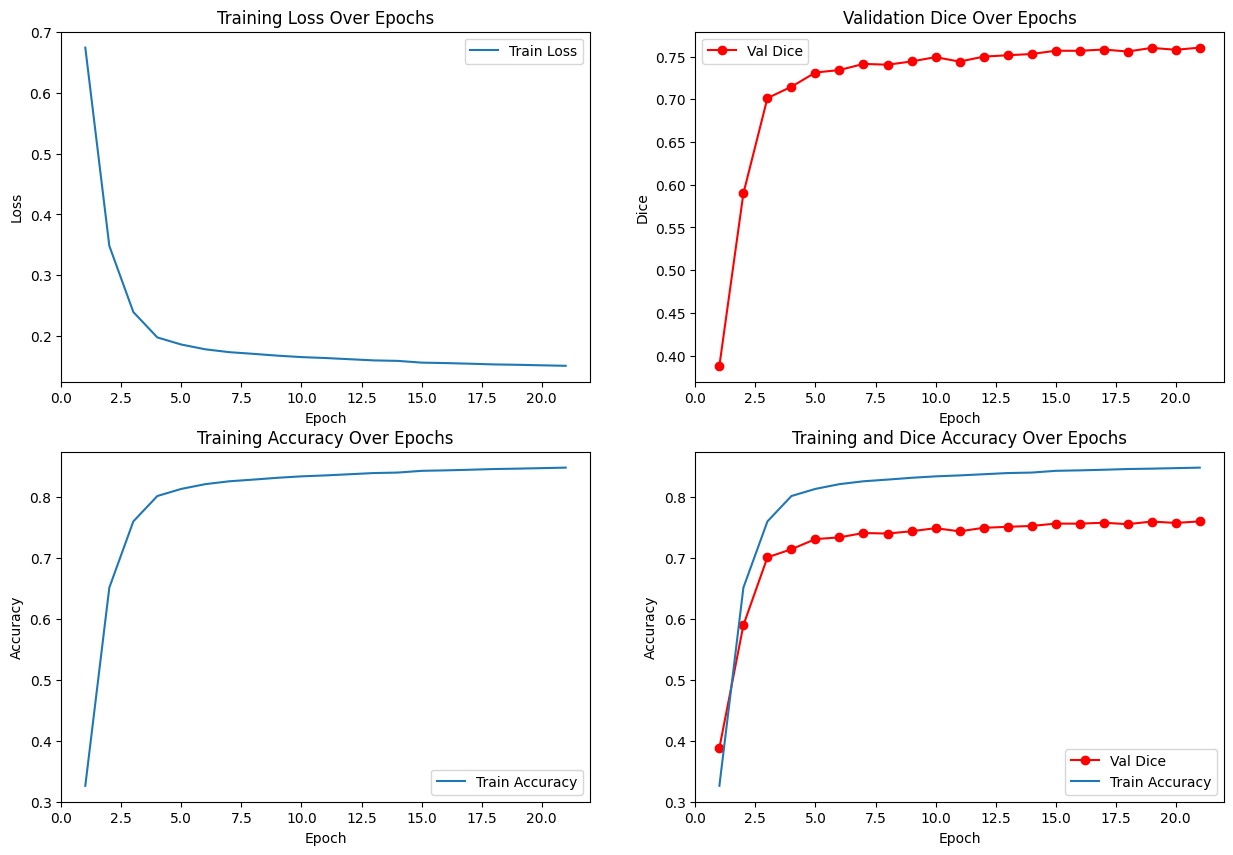

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()

axs[1, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[1, 1].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].set_title("Training and Dice Accuracy Over Epochs")
axs[1, 1].legend()

plt.show()

##Model Evaluation

In [ ]:
model.eval()
test_dice_list = []
with torch.no_grad():
    for val_data in tqdm(val_loader, leave=False):
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (128, 128, 128)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)

        dice_mean = dice_metric.aggregate().item()
        test_dice_list.append(dice_mean)
        dice_metric.reset()
        print(f"Validation Dice: {dice_mean:.4f}")

test_dice_mean = np.mean(test_dice_list)
std_dev = np.std(test_dice_list)
print(f"\nTest Dice: {test_dice_mean:.4f}, Std Dev: {std_dev:.4f}")

  2%|▏         | 1/50 [00:04<03:22,  4.14s/it]

Validation Dice: 0.5924


  4%|▍         | 2/50 [00:04<01:34,  1.97s/it]

Validation Dice: 0.6580


  6%|▌         | 3/50 [00:07<01:52,  2.39s/it]

Validation Dice: 0.8406


  8%|▊         | 4/50 [00:07<01:14,  1.63s/it]

Validation Dice: 0.7040


 10%|█         | 5/50 [00:10<01:22,  1.84s/it]

Validation Dice: 0.3823


 12%|█▏        | 6/50 [00:10<01:00,  1.37s/it]

Validation Dice: 0.7548


 14%|█▍        | 7/50 [00:13<01:19,  1.86s/it]

Validation Dice: 0.8358


 16%|█▌        | 8/50 [00:13<00:59,  1.41s/it]

Validation Dice: 0.5803


 18%|█▊        | 9/50 [00:16<01:15,  1.83s/it]

Validation Dice: 0.7886


 20%|██        | 10/50 [00:17<00:56,  1.41s/it]

Validation Dice: 0.7882


 22%|██▏       | 11/50 [00:19<01:04,  1.66s/it]

Validation Dice: 0.7909


 24%|██▍       | 12/50 [00:19<00:49,  1.29s/it]

Validation Dice: 0.8426


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ca4daaa8fe0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ca4daaa8fe0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():
     if w.is_alive():
           ^ ^ ^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Validation Dice: 0.7445


 28%|██▊       | 14/50 [00:23<00:49,  1.38s/it]

Validation Dice: 0.7417


 30%|███       | 15/50 [00:25<00:56,  1.63s/it]

Validation Dice: 0.8111


 32%|███▏      | 16/50 [00:25<00:43,  1.28s/it]

Validation Dice: 0.7280


 34%|███▍      | 17/50 [00:28<00:57,  1.74s/it]

Validation Dice: 0.7279


 36%|███▌      | 18/50 [00:29<00:43,  1.35s/it]

Validation Dice: 0.8155


 38%|███▊      | 19/50 [00:31<00:49,  1.60s/it]

Validation Dice: 0.7689


 40%|████      | 20/50 [00:31<00:37,  1.26s/it]

Validation Dice: 0.8097


 42%|████▏     | 21/50 [00:33<00:44,  1.55s/it]

Validation Dice: 0.8515


 44%|████▍     | 22/50 [00:34<00:34,  1.22s/it]

Validation Dice: 0.7881


 46%|████▌     | 23/50 [00:37<00:46,  1.72s/it]

Validation Dice: 0.8334


 48%|████▊     | 24/50 [00:37<00:34,  1.34s/it]

Validation Dice: 0.8375


 50%|█████     | 25/50 [00:40<00:45,  1.80s/it]

Validation Dice: 0.7612


 52%|█████▏    | 26/50 [00:41<00:33,  1.40s/it]

Validation Dice: 0.7807


 54%|█████▍    | 27/50 [00:43<00:37,  1.63s/it]

Validation Dice: 0.7203


 56%|█████▌    | 28/50 [00:43<00:28,  1.27s/it]

Validation Dice: 0.7508


 58%|█████▊    | 29/50 [00:45<00:32,  1.57s/it]

Validation Dice: 0.7993


 60%|██████    | 30/50 [00:46<00:24,  1.23s/it]

Validation Dice: 0.8228


 62%|██████▏   | 31/50 [00:48<00:29,  1.53s/it]

Validation Dice: 0.6188


 64%|██████▍   | 32/50 [00:49<00:21,  1.21s/it]

Validation Dice: 0.8000


 66%|██████▌   | 33/50 [00:51<00:25,  1.50s/it]

Validation Dice: 0.7959


 68%|██████▊   | 34/50 [00:51<00:19,  1.19s/it]

Validation Dice: 0.8002


 70%|███████   | 35/50 [00:54<00:25,  1.71s/it]

Validation Dice: 0.5999


 72%|███████▏  | 36/50 [00:55<00:18,  1.33s/it]

Validation Dice: 0.8170


 74%|███████▍  | 37/50 [00:57<00:20,  1.59s/it]

Validation Dice: 0.7573


 76%|███████▌  | 38/50 [00:57<00:15,  1.25s/it]

Validation Dice: 0.7257


 78%|███████▊  | 39/50 [01:00<00:19,  1.74s/it]

Validation Dice: 0.8395


 80%|████████  | 40/50 [01:01<00:13,  1.36s/it]

Validation Dice: 0.8191


 82%|████████▏ | 41/50 [01:03<00:16,  1.81s/it]

Validation Dice: 0.7395


 84%|████████▍ | 42/50 [01:04<00:11,  1.41s/it]

Validation Dice: 0.8229


 86%|████████▌ | 43/50 [01:06<00:11,  1.65s/it]

Validation Dice: 0.6634


 88%|████████▊ | 44/50 [01:07<00:07,  1.29s/it]

Validation Dice: 0.7922


 90%|█████████ | 45/50 [01:09<00:08,  1.77s/it]

Validation Dice: 0.7777


 92%|█████████▏| 46/50 [01:10<00:05,  1.37s/it]

Validation Dice: 0.8170


 94%|█████████▍| 47/50 [01:13<00:05,  1.81s/it]

Validation Dice: 0.8268


 96%|█████████▌| 48/50 [01:13<00:02,  1.40s/it]

Validation Dice: 0.8123


 98%|█████████▊| 49/50 [01:15<00:01,  1.63s/it]

Validation Dice: 0.7791


Validation Dice: 0.6680

Test Dice: 0.7585, Std Dev: 0.0867


In [ ]:
# Load the model
#load_model(model, '/content/drive/MyDrive/Checkpoints/150_epoch_1e-2_best_model.pth')
model.eval()
# Get validation data
val_img, val_seg = val_ds[0]
val_img_ = val_img.unsqueeze(0).cuda()

# Generate prediction
with torch.no_grad():
    pred_logits = model(val_img_)
    # Apply softmax to get probabilities
    pred_probs = torch.softmax(pred_logits, dim=1)
    # Get the class with highest probability
    pred_label = torch.argmax(pred_probs, dim=1, keepdim=True)  # shape [1,1,D,H,W]

# Convert to numpy for visualization
pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
val_seg_np = val_seg.squeeze().numpy()              # ground truth

print("Predicted label map shape:", pred_label_np.shape)

Predicted label map shape: (128, 128, 128)


In [ ]:
print(np.unique(pred_label_np), len(np.unique(pred_label_np)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] 45


###Changing contiguous labels to standard labels

In [ ]:
STD_LABEL_VALUES = np.array([0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253, 254, 255])

In [ ]:
std_pred_label = STD_LABEL_VALUES[pred_label_np]
std_val_seg = STD_LABEL_VALUES[val_seg_np.astype('int')]

In [ ]:
np.unique(std_pred_label)

array([  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  77,  80,
        85, 251, 252, 253, 254, 255])

###Visualization of Predicted and Ground Truth Labels

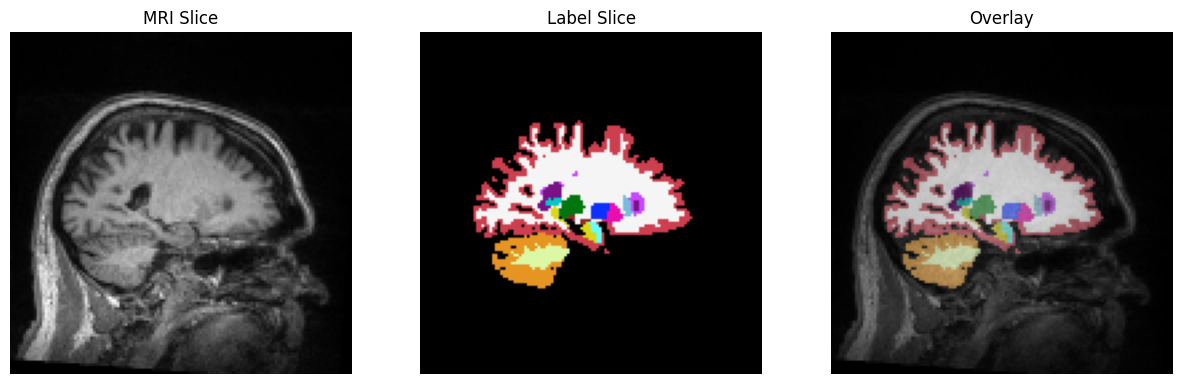

In [ ]:
#Prediction
visualize_image(val_img_np,std_pred_label, 75, array = True)

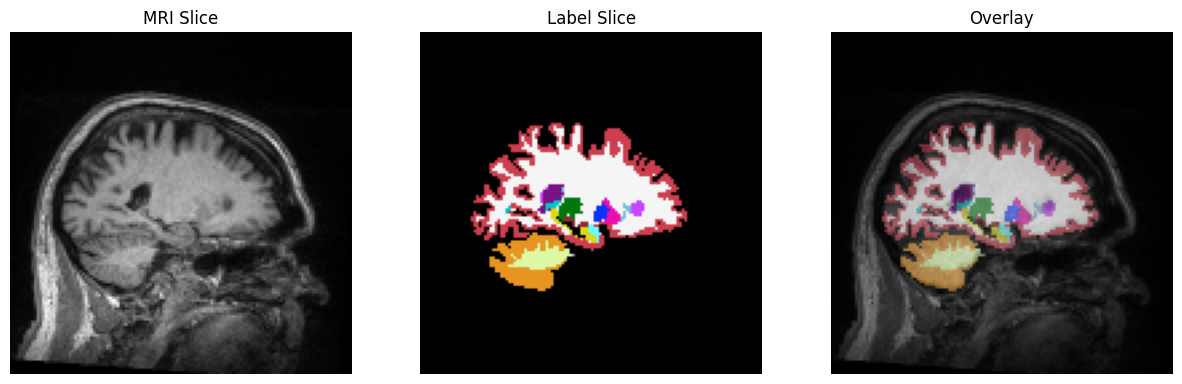

In [ ]:
#Ground Truth
visualize_image(val_img_np, std_val_seg, 75, array = True)